#Price forecasting with DT 3 algorithm and displaying buy and sell signals with indicators

[*********************100%%**********************]  1 of 1 completed


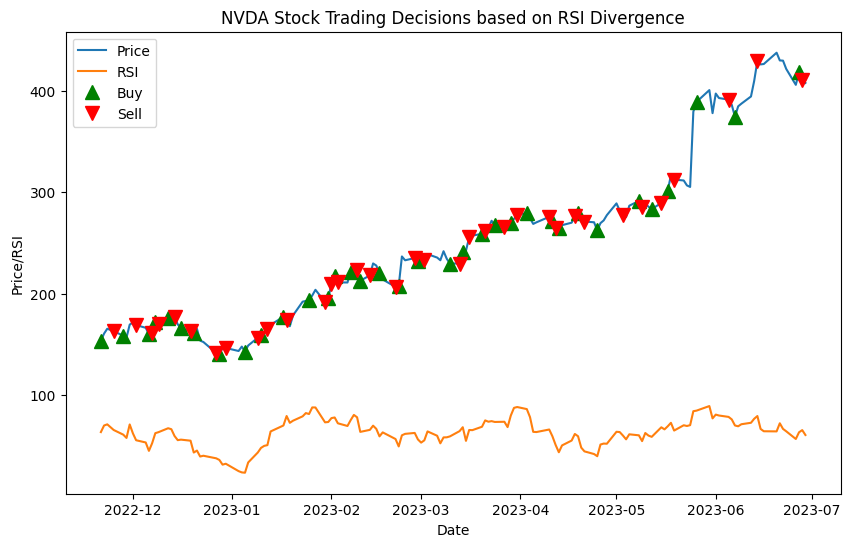

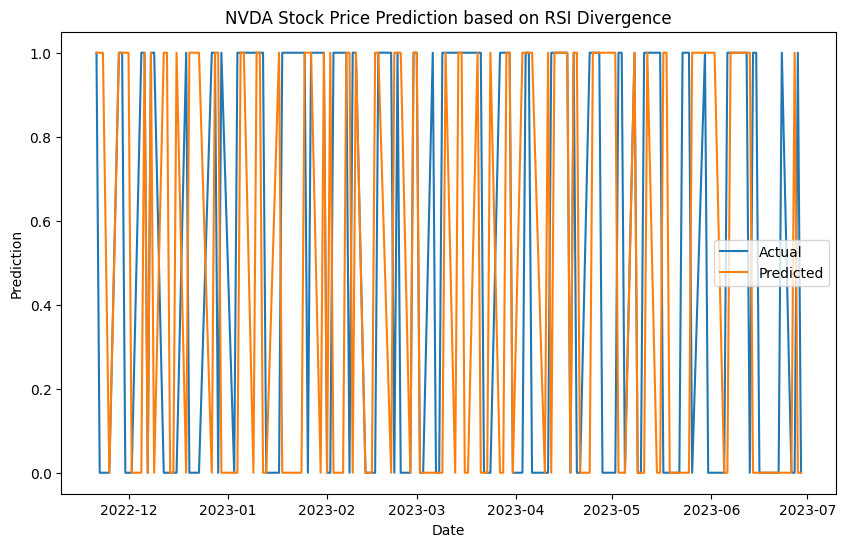

In [2]:
# Import necessary libraries
import yfinance as yf
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer

# Define a function to calculate the Relative Strength Index (RSI)
def calculate_rsi(data, period=14):
    # Calculate price changes
    delta = data['Close'].diff(1)
    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    # Calculate average gains and losses
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    # Calculate the Relative Strength (RS)
    rs = avg_gain / avg_loss
    # Calculate RSI
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

# Define the stock ticker symbol, start date, and end date
ticker = "NVDA"
start_date = "2020-07-01"
end_date = "2023-07-01"

# Download historical stock data
data = yf.download(ticker, start=start_date, end=end_date)

# Calculate daily returns and add them to the DataFrame
data['Return'] = data['Close'].pct_change().shift(-1)
data.dropna(inplace=True)

# Set the RSI period and calculate RSI for the data
rsi_period = 14
data['RSI'] = calculate_rsi(data, rsi_period)

# Prepare the data for machine learning
X = np.array(data['RSI']).reshape(-1, 1)
y = np.where(data['Return'].shift(-1) > 0, 1, 0)

# Split the data into training and testing sets
split = int(0.8 * len(data))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Impute missing values in the training data
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

# Create a decision tree classifier and fit it to the training data
model = DecisionTreeClassifier()
model.fit(X_train_imputed, y_train)

# Make predictions on the test data
X_test_imputed = imputer.transform(X_test)
y_pred = model.predict(X_test_imputed)

# Initialize lists to track buy and sell dates, prices, and calculate shares
buy_dates = []
sell_dates = []
buy_prices = []
sell_prices = []
shares = 0

# Determine buy and sell points based on the model predictions
for i in range(len(y_pred)):
    if y_pred[i] == 1:
        if shares == 0:
            buy_dates.append(data.index[i+split])
            buy_prices.append(data['Close'][i+split])
        shares += 10000 / data['Close'][i+split]
    else:
        if shares > 0:
            sell_dates.append(data.index[i+split])
            sell_prices.append(data['Close'][i+split])
        shares = 0

# Plot stock price, RSI, buy, and sell points
plt.figure(figsize=(10, 6))
plt.plot(data.index[split:], data['Close'][split:], label='Price')
plt.plot(data.index[split:], data['RSI'][split:], label='RSI')
plt.plot(buy_dates, buy_prices, 'g^', markersize=10, label='Buy')
plt.plot(sell_dates, sell_prices, 'rv', markersize=10, label='Sell')
plt.legend()
plt.title(f"{ticker} Stock Trading Decisions based on RSI Divergence")
plt.xlabel("Date")
plt.ylabel("Price/RSI")
plt.show()

# Plot actual and predicted stock price movements
plt.figure(figsize=(10, 6))
plt.plot(data.index[split:], y_test, label='Actual')
plt.plot(data.index[split:], y_pred, label='Predicted')
plt.legend()
plt.title(f"{ticker} Stock Price Prediction based on RSI Divergence")
plt.xlabel("Date")
plt.ylabel("Prediction")
plt.show()
